In [ ]:
import os
import cv2
import numpy as np
from tqdm import tqdm
import random

def augment_image(image, augmentation_type):
    """
    Apply augmentation based on the type specified with multiple conditions.
    """
    if augmentation_type == "light_increase":
        # Apply varying levels of light increase
        choice = np.random.choice([1.1, 1.3, 1.5])  # Random scaling factor for brightness
        beta = np.random.choice([20, 40, 60])  # Random adjustment to brightness
        return cv2.convertScaleAbs(image, alpha=choice, beta=beta)

    elif augmentation_type == "light_decrease":
        # Apply varying levels of light decrease
        choice = np.random.uniform(0.6, 0.8)  # Scaling factor for dimming
        beta = np.random.uniform(-30, -10)  # Random adjustment to dimming
        return cv2.convertScaleAbs(image, alpha=choice, beta=beta)

    elif augmentation_type == "gaussian_blur":
        # Apply Gaussian blur to the image
        return cv2.GaussianBlur(image, (5, 5), 0)  # Adjust the kernel size for more/less blurring

    elif augmentation_type == "light_placement":
        # Simulate varying light placements
        choice = np.random.choice(["center", "top_left", "top_right", "bottom_left", "bottom_right"])
        mask = np.zeros_like(image, dtype=np.float32)
        center = (image.shape[1] // 2, image.shape[0] // 2)

        if choice == "top_left":
            center = (image.shape[1] // 4, image.shape[0] // 4)
        elif choice == "top_right":
            center = (3 * image.shape[1] // 4, image.shape[0] // 4)
        elif choice == "bottom_left":
            center = (image.shape[1] // 4, 3 * image.shape[0] // 4)
        elif choice == "bottom_right":
            center = (3 * image.shape[1] // 4, 3 * image.shape[0] // 4)

        # Create gradient spotlight
        radius = min(image.shape[0], image.shape[1]) // 3
        cv2.circle(mask, center, radius, (1.0, 1.0, 1.0), -1)
        mask = cv2.GaussianBlur(mask, (41, 41), 0)  # Smooth edges

        # Blend mask with the image
        light_intensity = np.random.uniform(0.7, 1.2)
        blended_image = cv2.addWeighted(image.astype(np.float32), light_intensity, mask, 1 - light_intensity, 0)
        blended_image = np.clip(blended_image, 0, 255).astype(np.uint8)
        return blended_image


    else:
        raise ValueError("Invalid augmentation type!")


def augment_dataset(dataset_dir, output_dir):
    """
    Augment the dataset by applying various transformations.
    """
    # Create output directories if they don't exist
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # List all categories (folders)
    categories = os.listdir(dataset_dir)
    augmentation_types = ["light_increase", "light_decrease", "gaussian_blur", "light_placement"]

    for category in tqdm(categories, desc="Processing categories"):
        category_path = os.path.join(dataset_dir, category)
        if not os.path.isdir(category_path):
            continue

        # Create a subfolder for the augmented images
        augmented_category_path = os.path.join(output_dir, category)
        os.makedirs(augmented_category_path, exist_ok=True)

        # Process images in each category folder
        image_files = [f for f in os.listdir(category_path) if f.endswith(".jpg") or f.endswith(".png")]
        for image_file in tqdm(image_files, desc=f"Processing {category}"):
            image_path = os.path.join(category_path, image_file)
            image = cv2.imread(image_path)

            # Apply augmentations
            for aug_type in augmentation_types:
                augmented_image = augment_image(image, aug_type)

                # Save the augmented image
                aug_image_name = f"{image_file.split('.')[0]}_{aug_type}.{image_file.split('.')[-1]}"
                augmented_image_path = os.path.join(augmented_category_path, aug_image_name)
                cv2.imwrite(augmented_image_path, augmented_image)

# Paths to the dataset
dataset_dir = "/content/drive/MyDrive/CV_Project_2024-25iiits/dataset/test_images"
output_dir = "/content/drive/MyDrive/CV_Project_2024-25iiits/augmented_dataset/test"

# Augment the dataset
augment_dataset(dataset_dir, output_dir)



Processing categories: 100%|██████████| 22/22 [00:09<00:00,  2.41it/s]


In [ ]:
import os
import cv2
import numpy as np
from random import sample
from tqdm import tqdm

# Path to the dataset directory
base_path = "/content/drive/MyDrive/CV_Project_2024-25iiits/dataset"

# Target size for resizing
target_size = (160, 160)

# Probability of adding noise to an image
noise_probability = 0.2  # 20% of the images will have noise

# Function to add random noise to an image
def add_random_noise(image):
    noise = np.random.normal(0, 25, image.shape).astype(np.uint8)
    noisy_image = cv2.add(image, noise)
    return noisy_image

# Function to process images in a folder
def process_folder(folder_path):
    for subdir, _, files in os.walk(folder_path):
        # Select random files to add noise
        noisy_files = sample(files, k=int(len(files) * noise_probability)) if files else []

        for file_name in tqdm(files, desc=f"Processing {subdir}"):
            file_path = os.path.join(subdir, file_name)
            image = cv2.imread(file_path)

            if image is None:
                print(f"Warning: Could not read {file_path}. Skipping.")
                continue

            # Resize image to target size
            resized_image = cv2.resize(image, target_size)

            # Convert to RGB if not already
            if len(resized_image.shape) == 2 or resized_image.shape[2] == 1:
                resized_image = cv2.cvtColor(resized_image, cv2.COLOR_GRAY2RGB)

            '''# Add noise if the file is selected
            if file_name in noisy_files:
                resized_image = add_random_noise(resized_image)'''

            # Save the processed image (overwrite original file)
            cv2.imwrite(file_path, resized_image)

# Process train_images and test_images folders
train_images_path = os.path.join(base_path, "train_images")
test_images_path = os.path.join(base_path, "test_images")

print("Processing train_images...")
process_folder(train_images_path)

print("Processing test_images...")
process_folder(test_images_path)

print("All images processed successfully.")


Processing train_images...


Processing /content/drive/MyDrive/CV_Project_2024-25iiits/dataset/train_images: 0it [00:00, ?it/s]
Processing /content/drive/MyDrive/CV_Project_2024-25iiits/dataset/train_images/1: 100%|██████████| 35/35 [00:20<00:00,  1.70it/s]
Processing /content/drive/MyDrive/CV_Project_2024-25iiits/dataset/train_images/10: 100%|██████████| 35/35 [00:19<00:00,  1.75it/s]
Processing /content/drive/MyDrive/CV_Project_2024-25iiits/dataset/train_images/11: 100%|██████████| 34/34 [00:18<00:00,  1.84it/s]
Processing /content/drive/MyDrive/CV_Project_2024-25iiits/dataset/train_images/12: 100%|██████████| 35/35 [00:19<00:00,  1.77it/s]
Processing /content/drive/MyDrive/CV_Project_2024-25iiits/dataset/train_images/13: 100%|██████████| 35/35 [00:19<00:00,  1.79it/s]
Processing /content/drive/MyDrive/CV_Project_2024-25iiits/dataset/train_images/14: 100%|██████████| 35/35 [00:19<00:00,  1.77it/s]
Processing /content/drive/MyDrive/CV_Project_2024-25iiits/dataset/train_images/15: 100%|██████████| 34/34 [00:18<00:

Processing test_images...


Processing /content/drive/MyDrive/CV_Project_2024-25iiits/dataset/test_images: 0it [00:00, ?it/s]
Processing /content/drive/MyDrive/CV_Project_2024-25iiits/dataset/test_images/19: 100%|██████████| 5/5 [00:02<00:00,  1.86it/s]
Processing /content/drive/MyDrive/CV_Project_2024-25iiits/dataset/test_images/2: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]
Processing /content/drive/MyDrive/CV_Project_2024-25iiits/dataset/test_images/20: 100%|██████████| 5/5 [00:02<00:00,  1.76it/s]
Processing /content/drive/MyDrive/CV_Project_2024-25iiits/dataset/test_images/3: 100%|██████████| 5/5 [00:02<00:00,  1.74it/s]
Processing /content/drive/MyDrive/CV_Project_2024-25iiits/dataset/test_images/4: 100%|██████████| 5/5 [00:02<00:00,  1.75it/s]
Processing /content/drive/MyDrive/CV_Project_2024-25iiits/dataset/test_images/5: 100%|██████████| 5/5 [00:02<00:00,  1.80it/s]
Processing /content/drive/MyDrive/CV_Project_2024-25iiits/dataset/test_images/6: 100%|██████████| 5/5 [00:02<00:00,  1.74it/s]
Processing 

All images processed successfully.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: Error: credential propagation was unsuccessful

In [ ]:
import cv2
import mediapipe as mp
import os
import csv
import time

In [ ]:
import torch
import torch.nn as nn


class VGGFace160(nn.Module):
    def __init__(self, num_classes=15):
        super(VGGFace160, self).__init__()
        self.features = nn.Sequential(
            # Block 1
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 80x80

            # Block 2
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 40x40

            # Block 3
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 20x20

            # Block 4
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 10x10

            # Block 5
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)  # 5x5

            )

        # Adjusted classifier for 160x160 input size
        self.classifier = nn.Sequential(
            nn.Linear(512 * 5 * 5, 4096),  # Adjusted for output size of 5x5
            nn.ReLU(True),
            nn.Dropout(),

            nn.Linear(4096, 2048),
            nn.ReLU(True),
            nn.Dropout(),

            nn.Linear(2048, 1024),
            nn.ReLU(True),
            nn.Dropout(),

            nn.Linear(1024, 512),
            nn.ReLU(True),
            nn.Dropout(),

            nn.Linear(512, num_classes),
            nn.Softmax(dim=1)  # Softmax for classification output
        )

    def forward(self, x):
        x = self.features(x)
        print(x.shape)
        x = x.view(x.size(0), -1)
        print(x.shape)
        x = self.classifier(x)
        return x

# Example of instantiating the model for 20 classes
model = VGGFace160(num_classes=20)
# Calculate the feature map size after the convolutional layers
dummy_input = torch.randn(1, 3, 160, 160)  # Batch size 1, RGB image 160x160
feature_maps = model.features(dummy_input)  # Replace `features` with your model's feature extractor
print(feature_maps.shape)
dummy_input = torch.randn(1, 3, 160, 160)
output = model(dummy_input)
print(output.shape)

torch.Size([1, 512, 5, 5])
torch.Size([1, 512, 5, 5])
torch.Size([1, 12800])
torch.Size([1, 20])


In [ ]:
!ls -R /content/drive/MyDrive/CV_Project_2024-25iiits/dataset


/content/drive/MyDrive/CV_Project_2024-25iiits/dataset:
register.csv  test_images  train_images

/content/drive/MyDrive/CV_Project_2024-25iiits/dataset/test_images:
1  10  11  12  13  14  15  16  17  18  19  2  20  3  4	5  6  7  8  9

/content/drive/MyDrive/CV_Project_2024-25iiits/dataset/test_images/1:
image01.png  image02.png  image03.png  image04.png  image05.png

/content/drive/MyDrive/CV_Project_2024-25iiits/dataset/test_images/10:
image01.png  image02.png  image03.png  image04.png  image05.png

/content/drive/MyDrive/CV_Project_2024-25iiits/dataset/test_images/11:
image01.png  image02.png  image03.png  image04.png  image05.png

/content/drive/MyDrive/CV_Project_2024-25iiits/dataset/test_images/12:
image01.png  image02.png  image03.png  image04.png  image05.png

/content/drive/MyDrive/CV_Project_2024-25iiits/dataset/test_images/13:
image01.png  image02.png  image03.png  image04.png  image05.png

/content/drive/MyDrive/CV_Project_2024-25iiits/dataset/test_images/14:
image01.png  im

In [ ]:
print(df['class'].unique())

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import DataLoader, Dataset
import cv2
from tqdm import tqdm
from torchvision import transforms, datasets
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import os
from PIL import Image
import random
import pandas as pd

# Load the CSV file
df = pd.read_csv('/content/drive/MyDrive/CV_Project_2024-25iiits/dataset/register.csv')

# Get the number of unique classes
num_classes = df['class'].nunique()

# Parameters
NUM_CLASSES = 20
EPOCHS = 25
BATCH_SIZE = 35
IMAGE_HEIGHT = 160
IMAGE_WIDTH = 160
TRAINING_DATA_DIRECTORY = "/content/drive/MyDrive/CV_Project_2024-25iiits/dataset/train_images"
TESTING_DATA_DIRECTORY = "/content/drive/MyDrive/CV_Project_2024-25iiits/dataset/test_images"

# Add random noise to images
def add_noise(img):
    VARIABILITY = 35
    deviation = VARIABILITY * random.random()
    noise = np.random.normal(0, deviation, img.shape)
    img += noise
    np.clip(img, 0., 255.)
    return img

class IIITS_boys_hostel_FacesDataset(Dataset):
    def __init__(self, dataset_path, transform=None):
        self.dataset_path = dataset_path
        self.transform = transform
        self.image_paths = []
        self.labels = []
        self.class_to_idx = {}

        # Create a mapping from class folder names to integer labels
        for class_folder in os.listdir(dataset_path):
            class_folder_path = os.path.join(dataset_path, class_folder)
            if os.path.isdir(class_folder_path):
                class_index = len(self.class_to_idx)  # Assign index based on current length
                self.class_to_idx[class_folder] = class_index
                print(self.class_to_idx[class_folder])# Store class index as 0-based
                for img_file in os.listdir(class_folder_path):
                    if img_file.endswith(('.png', '.jpg', '.jpeg')):  # Ensure the file is an image
                        self.image_paths.append(os.path.join(class_folder_path, img_file))
                        self.labels.append(class_index)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert('RGB') # grayscale image
        label = self.labels[idx]  # No need to adjust label here

        if self.transform:
            image = self.transform(image)

        return image, label

# Transformations
transform = transforms.Compose([
    transforms.Resize((160, 160)),  # Resize to match input size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize to [-1, 1]
])

# Load datasets
train_dataset = IIITS_boys_hostel_FacesDataset(TRAINING_DATA_DIRECTORY, transform=transform)
test_dataset = IIITS_boys_hostel_FacesDataset(TESTING_DATA_DIRECTORY, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

import torch
import torch.nn as nn
import torch.nn.functional as F

class VGGFace160(nn.Module):
    def __init__(self, num_classes=15):
        super(VGGFace160, self).__init__()
        self.features = nn.Sequential(
            # Block 1
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 80x80

            # Block 2
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 40x40

            # Block 3
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 20x20

            # Block 4
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 10x10

            # Block 5
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)  # 5x5

            )

        # Adjusted classifier for 160x160 input size
        self.classifier = nn.Sequential(
            nn.Linear(512 * 5 * 5, 4096),  # Adjusted for output size of 5x5
            nn.ReLU(True),
            nn.Dropout(),

            nn.Linear(4096, 2048),
            nn.ReLU(True),
            nn.Dropout(),

            nn.Linear(2048, 1024),
            nn.ReLU(True),
            nn.Dropout(),

            nn.Linear(1024, 512),
            nn.ReLU(True),
            nn.Dropout(),

            nn.Linear(512, num_classes),
            nn.Softmax(dim=1)  # Softmax for classification output
        )

    def forward(self, x):
        x = self.features(x)
        print(x.shape)
        x = x.view(x.size(0), -1)
        print(x.shape)
        x = self.classifier(x)
        return x

# Example of instantiating the model for 20 classes
model = VGGFace160(num_classes=20)


# Instantiate the model, define the loss function and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VGGFace160().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0003)

# Training Loop
def train_model(model, train_loader, criterion, optimizer, epochs):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        for images, labels in tqdm(train_loader):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        print(f'Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader):.4f}, Accuracy: {100 * correct / total:.2f}%')

# Evaluation
def evaluate_model(model, test_loader, criterion):
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in tqdm(test_loader):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    print(f'Accuracy: {100 * correct / total:.2f}%')
    print("Classification Report:\n", classification_report(all_labels, all_preds))
    print("Confusion Matrix:\n", confusion_matrix(all_labels, all_preds))

# Train the model
train_model(model, train_loader, criterion, optimizer, EPOCHS)

# Evaluate the model
evaluate_model(model, test_loader, criterion)

# Mapping function to convert class indices to class names
def map_class_index_to_name(class_index):
    idx_to_class = {v: k for k, v in train_dataset.class_to_idx.items()}
    return idx_to_class.get(class_index, "Unknown")
'''
# Plot sample predictions with class mapping
def plot_sample_predictions(model, test_loader):
    model.eval()
    sample_images, sample_labels = next(iter(test_loader))
    sample_images = sample_images.to(device)
    outputs = model(sample_images)
    _, predicted = torch.max(outputs.data, 1)

    fig, axes = plt.subplots(3, 3, figsize=(9, 9))
    for i, ax in enumerate(axes.flat):
        ax.imshow(sample_images[i].cpu().squeeze(), cmap='gray')
        true_label = map_class_index_to_name(sample_labels[i].item())
        predicted_label = map_class_index_to_name(predicted[i].item())
        ax.set_title(f"Pred: {predicted_label}, True: {true_label}")
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# Plot predictions
plot_sample_predictions(model, test_loader)'''


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import DataLoader, Dataset
import os
from PIL import Image
import random
from torchvision import transforms
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix

# Parameters
NUM_CLASSES = 22
EPOCHS = 25
BATCH_SIZE = 35
IMAGE_HEIGHT = 160
IMAGE_WIDTH = 160
TRAINING_DATA_DIRECTORY = "/content/drive/MyDrive/CV_Project_2024-25iiits/dataset/train_images"
TESTING_DATA_DIRECTORY = "/content/drive/MyDrive/CV_Project_2024-25iiits/dataset/test_images"

# Add random noise to images
def add_noise(img):
    VARIABILITY = 35
    deviation = VARIABILITY * random.random()
    noise = np.random.normal(0, deviation, img.shape)
    img += noise
    np.clip(img, 0., 255.)
    return img

class IIITS_boys_hostel_FacesDataset(Dataset):
    def __init__(self, dataset_path, transform=None):
        self.dataset_path = dataset_path
        self.transform = transform
        self.image_paths = []
        self.labels = []
        self.class_to_idx = {}

        # Create a mapping from class folder names to integer labels
        for class_folder in os.listdir(dataset_path):
            class_folder_path = os.path.join(dataset_path, class_folder)
            if os.path.isdir(class_folder_path):
                class_index = len(self.class_to_idx)  # Assign index based on current length
                self.class_to_idx[class_folder] = class_index  # Store class index as 0-based
                for img_file in os.listdir(class_folder_path):
                    if img_file.endswith(('.png', '.jpg', '.jpeg')):  # Ensure the file is an image
                        self.image_paths.append(os.path.join(class_folder_path, img_file))
                        self.labels.append(class_index)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert('RGB')  # Ensure RGB image
        label = self.labels[idx]  # Label does not need adjustment

        if self.transform:
            image = self.transform(image)

        return image, label

# Transformations
transform = transforms.Compose([
    transforms.Resize((160, 160)),  # Resize to match input size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize to [-1, 1]
])

# Load datasets
train_dataset = IIITS_boys_hostel_FacesDataset(TRAINING_DATA_DIRECTORY, transform=transform)
test_dataset = IIITS_boys_hostel_FacesDataset(TESTING_DATA_DIRECTORY, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Define the VGGFace160 model
class VGGFace160(nn.Module):
    def __init__(self, num_classes=20):
        super(VGGFace160, self).__init__()
        self.features = nn.Sequential(
            # Block 1
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 80x80

            # Block 2
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 40x40

            # Block 3
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 20x20

            # Block 4
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 10x10

            # Block 5
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)  # 5x5
        )

        # Adjusted classifier for 160x160 input size
        self.classifier = nn.Sequential(
            nn.Linear(512 * 5 * 5, 4096),  # Adjusted for output size of 5x5
            nn.ReLU(True),
            nn.Dropout(),

            nn.Linear(4096, 2048),
            nn.ReLU(True),
            nn.Dropout(),

            nn.Linear(2048, 1024),
            nn.ReLU(True),
            nn.Dropout(),

            nn.Linear(1024, 512),
            nn.ReLU(True),
            nn.Dropout(),

            nn.Linear(512, num_classes),
            nn.Softmax(dim=1)  # Softmax for classification output
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)  # Flatten before passing to classifier
        x = self.classifier(x)
        return x

# Instantiate the model for 20 classes
model = VGGFace160(num_classes=NUM_CLASSES)

# Instantiate the model, define the loss function and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0003)

# Training Loop
def train_model(model, train_loader, criterion, optimizer, epochs):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        for images, labels in tqdm(train_loader):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        print(f'Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader):.4f}, Accuracy: {100 * correct / total:.2f}%')

# Evaluation
def evaluate_model(model, test_loader, criterion):
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in tqdm(test_loader):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    print(f'Accuracy: {100 * correct / total:.2f}%')
    print("Classification Report:\n", classification_report(all_labels, all_preds))
    print("Confusion Matrix:\n", confusion_matrix(all_labels, all_preds))

# Train the model
train_model(model, train_loader, criterion, optimizer, EPOCHS)

# Evaluate the model
evaluate_model(model, test_loader, criterion)

# Mapping function to convert class indices to class names
def map_class_index_to_name(class_index):
    idx_to_class = {v: k for k, v in train_dataset.class_to_idx.items()}
    return idx_to_class.get(class_index, "Unknown")


100%|██████████| 20/20 [13:37<00:00, 40.88s/it]


Epoch [1/25], Loss: 2.9958, Accuracy: 4.17%


100%|██████████| 20/20 [13:09<00:00, 39.48s/it]


Epoch [2/25], Loss: 2.9958, Accuracy: 5.17%


 20%|██        | 4/20 [02:37<10:29, 39.37s/it]

In [ ]:
import pandas as pd

# Load the CSV file
input_file = "/content/drive/MyDrive/CV_Project_2024-25iiits/dataset/register.csv"  # Replace with your CSV file path
output_file = "/content/drive/MyDrive/CV_Project_2024-25iiits/dataset/register.csv"  # Replace with desired output file path

# Read the CSV file into a DataFrame
df = pd.read_csv(input_file, header=None)  # Assuming no header in the original file

# Assign column names to columns 0 and 1
df.rename(columns={0: 'class', 1: 'name'}, inplace=True)

# Save the updated DataFrame back to a CSV file
df.to_csv(output_file, index=False)

print(f"Column names added and file saved as {output_file}")


Column names added and file saved as /content/drive/MyDrive/CV_Project_2024-25iiits/dataset/register.csv


Epoch 1/35 - Training: 100%|██████████| 22/22 [00:47<00:00,  2.15s/it]


Epoch [1/35] | Train Loss: 2.4309, Train Acc: 27.09%


Epoch 2/35 - Training: 100%|██████████| 22/22 [00:45<00:00,  2.06s/it]


Epoch [2/35] | Train Loss: 1.1443, Train Acc: 64.01%


Epoch 3/35 - Training: 100%|██████████| 22/22 [00:44<00:00,  2.03s/it]


Epoch [3/35] | Train Loss: 0.5785, Train Acc: 82.46%


Epoch 4/35 - Training: 100%|██████████| 22/22 [00:44<00:00,  2.04s/it]


Epoch [4/35] | Train Loss: 0.3687, Train Acc: 90.05%


Epoch 5/35 - Training: 100%|██████████| 22/22 [00:44<00:00,  2.03s/it]


Epoch [5/35] | Train Loss: 0.2537, Train Acc: 93.06%


Epoch 6/35 - Training: 100%|██████████| 22/22 [00:44<00:00,  2.01s/it]


Epoch [6/35] | Train Loss: 0.1613, Train Acc: 95.81%


Epoch 7/35 - Training: 100%|██████████| 22/22 [00:44<00:00,  2.03s/it]


Epoch [7/35] | Train Loss: 0.1179, Train Acc: 96.60%


Epoch 8/35 - Training: 100%|██████████| 22/22 [00:43<00:00,  1.98s/it]


Epoch [8/35] | Train Loss: 0.1155, Train Acc: 96.86%


Epoch 9/35 - Training: 100%|██████████| 22/22 [00:44<00:00,  2.02s/it]


Epoch [9/35] | Train Loss: 0.0969, Train Acc: 96.99%


Epoch 10/35 - Training: 100%|██████████| 22/22 [00:44<00:00,  2.02s/it]


Epoch [10/35] | Train Loss: 0.0612, Train Acc: 97.77%


Epoch 11/35 - Training: 100%|██████████| 22/22 [00:43<00:00,  2.00s/it]


Epoch [11/35] | Train Loss: 0.0549, Train Acc: 98.17%


Epoch 12/35 - Training: 100%|██████████| 22/22 [00:44<00:00,  2.02s/it]


Epoch [12/35] | Train Loss: 0.0358, Train Acc: 99.08%


Epoch 13/35 - Training: 100%|██████████| 22/22 [00:44<00:00,  2.00s/it]


Epoch [13/35] | Train Loss: 0.0248, Train Acc: 99.35%


Epoch 14/35 - Training: 100%|██████████| 22/22 [00:44<00:00,  2.01s/it]


Epoch [14/35] | Train Loss: 0.0329, Train Acc: 98.95%


Epoch 15/35 - Training: 100%|██████████| 22/22 [00:43<00:00,  2.00s/it]


Epoch [15/35] | Train Loss: 0.0148, Train Acc: 99.87%


Epoch 16/35 - Training: 100%|██████████| 22/22 [00:43<00:00,  1.99s/it]


Epoch [16/35] | Train Loss: 0.0181, Train Acc: 99.21%


Epoch 17/35 - Training: 100%|██████████| 22/22 [00:44<00:00,  2.00s/it]


Epoch [17/35] | Train Loss: 0.0133, Train Acc: 99.61%


Epoch 18/35 - Training: 100%|██████████| 22/22 [00:43<00:00,  1.99s/it]


Epoch [18/35] | Train Loss: 0.0125, Train Acc: 99.74%


Epoch 19/35 - Training: 100%|██████████| 22/22 [00:44<00:00,  2.02s/it]


Epoch [19/35] | Train Loss: 0.0168, Train Acc: 99.48%


Epoch 20/35 - Training: 100%|██████████| 22/22 [00:43<00:00,  1.99s/it]


Epoch [20/35] | Train Loss: 0.0064, Train Acc: 99.87%


Epoch 21/35 - Training: 100%|██████████| 22/22 [00:44<00:00,  2.04s/it]


Epoch [21/35] | Train Loss: 0.0115, Train Acc: 99.61%


Epoch 22/35 - Training: 100%|██████████| 22/22 [00:44<00:00,  2.02s/it]


Epoch [22/35] | Train Loss: 0.0118, Train Acc: 99.61%


Epoch 23/35 - Training: 100%|██████████| 22/22 [00:44<00:00,  2.03s/it]


Epoch [23/35] | Train Loss: 0.0271, Train Acc: 99.48%


Epoch 24/35 - Training: 100%|██████████| 22/22 [00:44<00:00,  2.03s/it]


Epoch [24/35] | Train Loss: 0.0149, Train Acc: 99.48%


Epoch 25/35 - Training: 100%|██████████| 22/22 [00:43<00:00,  2.00s/it]


Epoch [25/35] | Train Loss: 0.0552, Train Acc: 98.82%


Epoch 26/35 - Training: 100%|██████████| 22/22 [00:44<00:00,  2.03s/it]


Epoch [26/35] | Train Loss: 0.0224, Train Acc: 99.35%


Epoch 27/35 - Training: 100%|██████████| 22/22 [00:44<00:00,  2.03s/it]


Epoch [27/35] | Train Loss: 0.0179, Train Acc: 99.21%


Epoch 28/35 - Training: 100%|██████████| 22/22 [00:44<00:00,  2.02s/it]


Epoch [28/35] | Train Loss: 0.0230, Train Acc: 99.35%


Epoch 29/35 - Training: 100%|██████████| 22/22 [00:44<00:00,  2.04s/it]


Epoch [29/35] | Train Loss: 0.0129, Train Acc: 99.87%


Epoch 30/35 - Training: 100%|██████████| 22/22 [00:44<00:00,  2.01s/it]


Epoch [30/35] | Train Loss: 0.0047, Train Acc: 99.87%


Epoch 31/35 - Training: 100%|██████████| 22/22 [00:44<00:00,  2.03s/it]


Epoch [31/35] | Train Loss: 0.0092, Train Acc: 99.87%


Epoch 32/35 - Training: 100%|██████████| 22/22 [00:44<00:00,  2.03s/it]


Epoch [32/35] | Train Loss: 0.0131, Train Acc: 99.61%


Epoch 33/35 - Training: 100%|██████████| 22/22 [00:44<00:00,  2.01s/it]


Epoch [33/35] | Train Loss: 0.0137, Train Acc: 99.48%


Epoch 34/35 - Training: 100%|██████████| 22/22 [00:44<00:00,  2.03s/it]


Epoch [34/35] | Train Loss: 0.0194, Train Acc: 99.21%


Epoch 35/35 - Training: 100%|██████████| 22/22 [00:44<00:00,  2.02s/it]


Epoch [35/35] | Train Loss: 0.0149, Train Acc: 99.61%


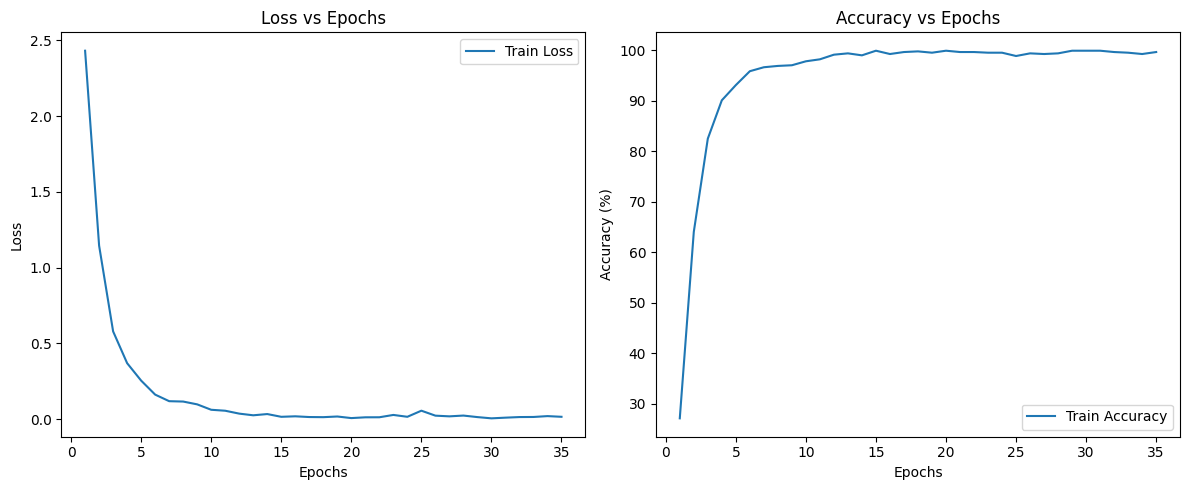

<ipython-input-4-767aec4d921b>:298: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pth"))
Evaluating: 100%|██████████| 4/4 [00:04

Accuracy: 82.46%
Precision: 0.82, Recall: 0.82, F1-Score: 0.82
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      0.80      0.89         5
           2       1.00      1.00      1.00         5
           3       0.75      0.60      0.67         5
           4       0.71      1.00      0.83         5
           5       0.80      0.80      0.80         5
           6       0.83      1.00      0.91         5
           7       1.00      0.80      0.89         5
           8       1.00      1.00      1.00         5
           9       1.00      1.00      1.00         5
          10       0.83      1.00      0.91         5
          11       1.00      1.00      1.00         5
          12       1.00      1.00      1.00         5
          13       0.83      1.00      0.91         5
          14       1.00      0.80      0.89         5
          15       1.00      1.00      1.00     

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import DataLoader, Dataset
import os
from PIL import Image
import random
from torchvision import transforms
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix

# Parameters
NUM_CLASSES = 22
EPOCHS = 35
BATCH_SIZE = 35
IMAGE_HEIGHT = 160
IMAGE_WIDTH = 160
TRAINING_DATA_DIRECTORY = "/content/drive/MyDrive/CV_Project_2024-25iiits/dataset/train_images"
TESTING_DATA_DIRECTORY = "/content/drive/MyDrive/CV_Project_2024-25iiits/dataset/test_images"

# Add random noise to images
def add_noise(img):
    VARIABILITY = 35
    deviation = VARIABILITY * random.random()
    noise = np.random.normal(0, deviation, img.shape)
    img += noise
    np.clip(img, 0., 255.)
    return img

class IIITS_boys_hostel_FacesDataset(Dataset):
    def __init__(self, dataset_path, transform=None):
        self.dataset_path = dataset_path
        self.transform = transform
        self.image_paths = []
        self.labels = []

        # Loop through folders in the dataset path
        for class_folder in os.listdir(dataset_path):
            class_folder_path = os.path.join(dataset_path, class_folder)
            if os.path.isdir(class_folder_path):
                # Convert folder name to label (folder name is assumed to be '1', '2', ..., '20')
                try:
                    class_index = int(class_folder) - 1  # Convert folder name to zero-based label
                except ValueError:
                    raise ValueError(f"Folder name '{class_folder}' is not a valid integer.")

                # Add images and labels
                for img_file in os.listdir(class_folder_path):
                    if img_file.endswith(('.png', '.jpg', '.jpeg')):  # Ensure the file is an image
                        self.image_paths.append(os.path.join(class_folder_path, img_file))
                        self.labels.append(class_index)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert('RGB')  # Ensure RGB image
        label = self.labels[idx]  # Label does not need adjustment

        if self.transform:
            image = self.transform(image)

        return image, label

# Transformations
transform = transforms.Compose([
    transforms.Resize((160, 160)),  # Resize to match input size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize to [-1, 1]
])

# Load datasets
train_dataset = IIITS_boys_hostel_FacesDataset(TRAINING_DATA_DIRECTORY, transform=transform)
test_dataset = IIITS_boys_hostel_FacesDataset(TESTING_DATA_DIRECTORY, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
'''
# Define the VGGFace160 model
class VGGFace160(nn.Module):
    def __init__(self, num_classes=20):
        super(VGGFace160, self).__init__()
        self.features = nn.Sequential(
            # Block 1
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 80x80

            # Block 2
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 40x40

            # Block 3
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 20x20

            # Block 4
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 10x10

            # Block 5
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)  # 5x5
        )

        # Adjusted classifier for 160x160 input size
        self.classifier = nn.Sequential(
            nn.Linear(512 * 5 * 5, 4096),  # Adjusted for output size of 5x5
            nn.ReLU(True),
            #nn.Dropout(),

            nn.Linear(4096, 2048),
            nn.ReLU(True),
            #nn.Dropout(),

            nn.Linear(2048, 1024),
            nn.ReLU(True),
            #nn.Dropout(),

            nn.Linear(1024, 512),
            nn.ReLU(True),
            nn.Dropout(0.5),

            nn.Linear(512, num_classes),
            #nn.Softmax(dim=1)  # Softmax for classification output
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)  # Flatten before passing to classifier
        x = self.classifier(x)
        return x

# Instantiate the model for 20 classes
model = VGGFace160(num_classes=NUM_CLASSES)'''
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * (IMAGE_HEIGHT // 8) * (IMAGE_WIDTH // 8), 512)
        self.fc2 = nn.Linear(512, NUM_CLASSES)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))
        x = x.view(-1, 128 * (IMAGE_HEIGHT // 8) * (IMAGE_WIDTH // 8))
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Instantiate the model, define the loss function and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNNModel().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0003)
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score

# Updated training function with saving the best model and tracking metrics
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score

# Updated training function without validation
def train_model(model, train_loader, criterion, optimizer, epochs):
    model.train()
    best_train_acc = 0.0
    train_losses, train_accuracies = [], []

    for epoch in range(epochs):
        running_loss, correct, total = 0.0, 0, 0
        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} - Training"):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_acc = 100 * correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        # Save the best model based on training accuracy
        if train_acc > best_train_acc:
            best_train_acc = train_acc
            torch.save(model.state_dict(), "best_model.pth")

        print(f"Epoch [{epoch+1}/{epochs}] | Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")

    # Plot training metrics
    plot_metrics(train_losses, train_accuracies)

# Evaluation function (remains the same)
def evaluate_model(model, data_loader, criterion):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in tqdm(data_loader, desc="Evaluating"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_loss = running_loss / len(data_loader)
    accuracy = 100 * correct / total

    precision = precision_score(all_labels, all_preds, average="weighted")
    recall = recall_score(all_labels, all_preds, average="weighted")
    f1 = f1_score(all_labels, all_preds, average="weighted")

    print(f"Accuracy: {accuracy:.2f}%")
    print(f"Precision: {precision:.2f}, Recall: {recall:.2f}, F1-Score: {f1:.2f}")
    print("Classification Report:\n", classification_report(all_labels, all_preds))
    print("Confusion Matrix:\n", confusion_matrix(all_labels, all_preds))

    return avg_loss, accuracy

# Plotting function
def plot_metrics(losses, accuracies):
    epochs = range(1, len(losses) + 1)

    plt.figure(figsize=(12, 5))
    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, losses, label="Train Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Loss vs Epochs")
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracies, label="Train Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy (%)")
    plt.title("Accuracy vs Epochs")
    plt.legend()

    plt.tight_layout()
    plt.show()

# Train the model
train_model(model, train_loader, criterion, optimizer, EPOCHS)

# Load the best model for final evaluation
model.load_state_dict(torch.load("best_model.pth"))
evaluate_model(model, test_loader, criterion)



# Mapping function to convert class indices to class names
def map_class_index_to_name(class_index):
    idx_to_class = {v: k for k, v in train_dataset.class_to_idx.items()}
    return idx_to_class.get(class_index, "Unknown")

In [ ]:
import matplotlib.pyplot as plt

# Function to plot test images with true and predicted labels
def plot_predictions(model, test_loader, num_classes=20, images_per_class=5):
    model.load_state_dict(torch.load("best_model.pth", map_location=device))
    model.to(device)
    model.eval()
    class_images = {i: [] for i in range(num_classes)}  # Dictionary to store images for each class
    class_true_labels = {i: [] for i in range(num_classes)}
    class_pred_labels = {i: [] for i in range(num_classes)}

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)

            for img, true_label, pred_label in zip(images, labels, predicted):
                if len(class_images[true_label.item()]) < images_per_class:
                    class_images[true_label.item()].append(img.cpu())
                    class_true_labels[true_label.item()].append(true_label.item())
                    class_pred_labels[true_label.item()].append(pred_label.item())

                # Stop when we have enough images per class
                if all(len(v) >= images_per_class for v in class_images.values()):
                    break

    # Plot the images with true and predicted labels
    fig, axes = plt.subplots(num_classes, images_per_class, figsize=(20, num_classes * 5))
    for class_id in range(num_classes):
        for img_idx in range(images_per_class):
            ax = axes[class_id, img_idx]
            img = class_images[class_id][img_idx]
            true_label = class_true_labels[class_id][img_idx]
            pred_label = class_pred_labels[class_id][img_idx]

            # Convert tensor image to numpy for visualization
            img = img.permute(1, 2, 0).numpy()  # Change shape from (C, H, W) to (H, W, C)
            img = (img * 0.5 + 0.5) * 255  # De-normalize and scale to [0, 255]
            img = img.astype(np.uint8)

            ax.imshow(img)
            ax.axis('off')
            ax.set_title(f"True: {true_label}\nPred: {pred_label}", color="green" if true_label == pred_label else "red")

    plt.tight_layout()
    plt.show()

# Plot predictions
plot_predictions(model, test_loader, num_classes=NUM_CLASSES, images_per_class=5)


Output hidden; open in https://colab.research.google.com to view.

100%|██████████| 4/4 [00:00<00:00,  6.41it/s]


Accuracy: 82.73%
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      0.80      0.89         5
           2       1.00      1.00      1.00         5
           3       0.75      0.60      0.67         5
           4       0.83      1.00      0.91         5
           5       1.00      0.60      0.75         5
           6       0.83      1.00      0.91         5
           7       0.80      0.80      0.80         5
           8       1.00      1.00      1.00         5
           9       1.00      1.00      1.00         5
          10       0.83      1.00      0.91         5
          11       1.00      1.00      1.00         5
          12       0.83      1.00      0.91         5
          13       0.83      1.00      0.91         5
          14       1.00      0.80      0.89         5
          15       1.00      1.00      1.00         5
          16       0.80      0.80      0

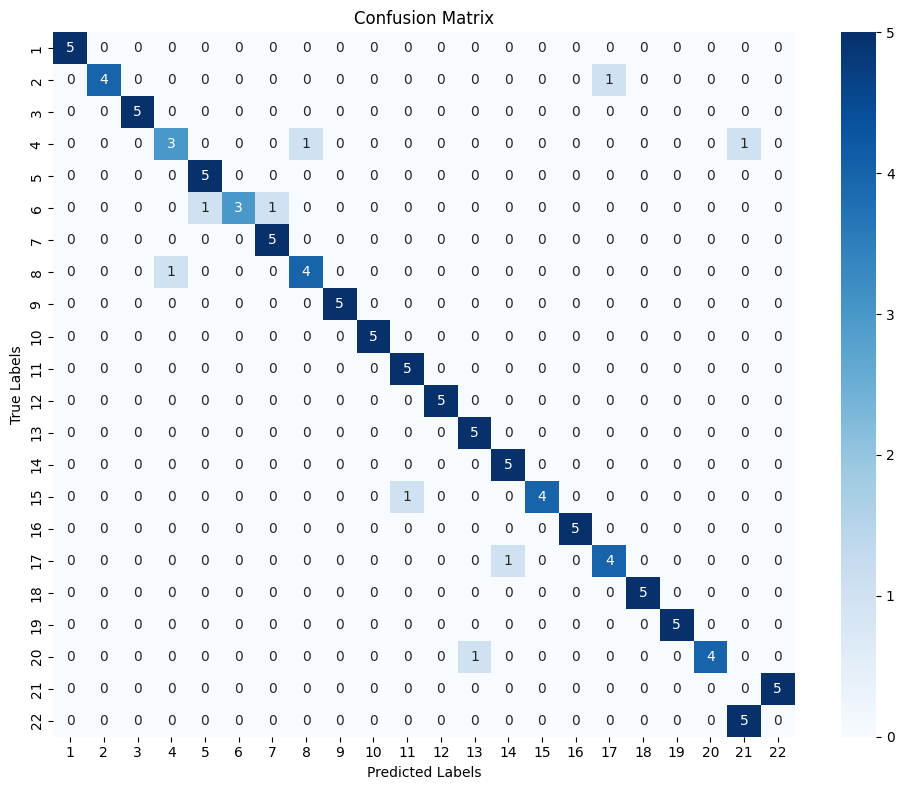

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay

def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.show()
def evaluate_model(model, test_loader, criterion):
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in tqdm(test_loader):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = 100 * correct / total
    print(f'Accuracy: {accuracy:.2f}%')
    print("Classification Report:\n", classification_report(all_labels, all_preds))

    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds)

    # Plot confusion matrix
    class_names = [str(i+1) for i in range(NUM_CLASSES)]  # Adjust class names as needed
    plot_confusion_matrix(cm, class_names)
evaluate_model(model, test_loader, criterion)

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import DataLoader, Dataset
import os
from PIL import Image
import random
from torchvision import transforms
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix

# Parameters
NUM_CLASSES = 22
EPOCHS = 35
BATCH_SIZE = 35
IMAGE_HEIGHT = 160
IMAGE_WIDTH = 160
TRAINING_DATA_DIRECTORY = "/content/drive/MyDrive/CV_Project_2024-25iiits/augmented_dataset/train"
TESTING_DATA_DIRECTORY = "/content/drive/MyDrive/CV_Project_2024-25iiits/augmented_dataset/test"

# Add random noise to images
def add_noise(img):
    VARIABILITY = 35
    deviation = VARIABILITY * random.random()
    noise = np.random.normal(0, deviation, img.shape)
    img += noise
    np.clip(img, 0., 255.)
    return img

class IIITS_boys_hostel_FacesDataset(Dataset):
    def __init__(self, dataset_path, transform=None):
        self.dataset_path = dataset_path
        self.transform = transform
        self.image_paths = []
        self.labels = []

        # Loop through folders in the dataset path
        for class_folder in os.listdir(dataset_path):
            class_folder_path = os.path.join(dataset_path, class_folder)
            if os.path.isdir(class_folder_path):
                # Convert folder name to label (folder name is assumed to be '1', '2', ..., '20')
                try:
                    class_index = int(class_folder) - 1  # Convert folder name to zero-based label
                except ValueError:
                    raise ValueError(f"Folder name '{class_folder}' is not a valid integer.")

                # Add images and labels
                for img_file in os.listdir(class_folder_path):
                    if img_file.endswith(('.png', '.jpg', '.jpeg')):  # Ensure the file is an image
                        self.image_paths.append(os.path.join(class_folder_path, img_file))
                        self.labels.append(class_index)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert('RGB')  # Ensure RGB image
        label = self.labels[idx]  # Label does not need adjustment

        if self.transform:
            image = self.transform(image)

        return image, label

# Transformations
transform = transforms.Compose([
    transforms.Resize((160, 160)),  # Resize to match input size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize to [-1, 1]
])

# Load datasets
train_dataset = IIITS_boys_hostel_FacesDataset(TRAINING_DATA_DIRECTORY, transform=transform)
test_dataset = IIITS_boys_hostel_FacesDataset(TESTING_DATA_DIRECTORY, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
'''
# Define the VGGFace160 model
class VGGFace160(nn.Module):
    def __init__(self, num_classes=20):
        super(VGGFace160, self).__init__()
        self.features = nn.Sequential(
            # Block 1
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 80x80

            # Block 2
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 40x40

            # Block 3
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 20x20

            # Block 4
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 10x10

            # Block 5
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)  # 5x5
        )

        # Adjusted classifier for 160x160 input size
        self.classifier = nn.Sequential(
            nn.Linear(512 * 5 * 5, 4096),  # Adjusted for output size of 5x5
            nn.ReLU(True),
            #nn.Dropout(),

            nn.Linear(4096, 2048),
            nn.ReLU(True),
            #nn.Dropout(),

            nn.Linear(2048, 1024),
            nn.ReLU(True),
            #nn.Dropout(),

            nn.Linear(1024, 512),
            nn.ReLU(True),
            nn.Dropout(0.5),

            nn.Linear(512, num_classes),
            #nn.Softmax(dim=1)  # Softmax for classification output
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)  # Flatten before passing to classifier
        x = self.classifier(x)
        return x

# Instantiate the model for 20 classes
model = VGGFace160(num_classes=NUM_CLASSES)'''
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * (IMAGE_HEIGHT // 8) * (IMAGE_WIDTH // 8), 512)
        self.fc2 = nn.Linear(512, NUM_CLASSES)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))
        x = x.view(-1, 128 * (IMAGE_HEIGHT // 8) * (IMAGE_WIDTH // 8))
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Instantiate the model, define the loss function and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNNModel().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0003)
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score

# Updated training function with saving the best model and tracking metrics
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score

# Updated training function without validation
def train_model(model, train_loader, criterion, optimizer, epochs):
    model.train()
    best_train_acc = 0.0
    train_losses, train_accuracies = [], []

    for epoch in range(epochs):
        running_loss, correct, total = 0.0, 0, 0
        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} - Training"):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_acc = 100 * correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        # Save the best model based on training accuracy
        if train_acc > best_train_acc:
            best_train_acc = train_acc
            torch.save(model.state_dict(), "best_model.pth")

        print(f"Epoch [{epoch+1}/{epochs}] | Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")

    # Plot training metrics
    plot_metrics(train_losses, train_accuracies)

# Evaluation function (remains the same)
def evaluate_model(model, data_loader, criterion):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in tqdm(data_loader, desc="Evaluating"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_loss = running_loss / len(data_loader)
    accuracy = 100 * correct / total

    precision = precision_score(all_labels, all_preds, average="weighted")
    recall = recall_score(all_labels, all_preds, average="weighted")
    f1 = f1_score(all_labels, all_preds, average="weighted")

    print(f"Accuracy: {accuracy:.2f}%")
    print(f"Precision: {precision:.2f}, Recall: {recall:.2f}, F1-Score: {f1:.2f}")
    print("Classification Report:\n", classification_report(all_labels, all_preds))
    print("Confusion Matrix:\n", confusion_matrix(all_labels, all_preds))

    return avg_loss, accuracy

# Plotting function
def plot_metrics(losses, accuracies):
    epochs = range(1, len(losses) + 1)

    plt.figure(figsize=(12, 5))
    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, losses, label="Train Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Loss vs Epochs")
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracies, label="Train Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy (%)")
    plt.title("Accuracy vs Epochs")
    plt.legend()

    plt.tight_layout()
    plt.show()

# Train the model
train_model(model, train_loader, criterion, optimizer, EPOCHS)

# Load the best model for final evaluation
model.load_state_dict(torch.load("best_model.pth"))
evaluate_model(model, test_loader, criterion)



# Mapping function to convert class indices to class names
def map_class_index_to_name(class_index):
    idx_to_class = {v: k for k, v in train_dataset.class_to_idx.items()}
    return idx_to_class.get(class_index, "Unknown")

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/CV_Project_2024-25iiits/augmented_dataset/train'